In [7]:
%load_ext autoreload

%autoreload complete

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Numeric NPAD Checks

In this notebook, we will check and use the numerical version of NPAD

In [8]:
import sys
from dataclasses import dataclass, field
from itertools import product

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scipy.linalg as la
import sympy
from icecream import ic

rng = np.random.default_rng()

from npad_cupy.gpu import (
    extract_num_params,
    npad_diagonalize,
    npad_eliminate_couplings,
    npad_eliminate_largest_coupling,
)
from npad_cupy.gpu.utils import givens_rot_numeric, unitary_transformation

np.set_printoptions(precision=4)

mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["font.size"] = 25
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["lines.markersize"] = 8
mpl.rcParams["text.usetex"] = True
mpl.rcParams["legend.fontsize"] = 20
mpl.rcParams["axes.titlesize"] = 20

# Checking matrix element magnitude
We will define a function below that will plot a matrix in grayscale with a colorbar indicating the absolute value of the matrix elements.
We're defining another function to plot only the off-diagonal elements. 

TODO: It is probably a good idea to check that NPAD works for different random matrices with ther same energy spectrum. 


In [9]:
from matplotlib.colors import LogNorm


def plot_matelm_mag(H: np.ndarray, scale="log"):
    fig, ax = plt.subplots(1, 1, layout="constrained")
    absH = np.abs(H)
    P1 = ax.imshow(
        absH, cmap="binary", norm=LogNorm(vmin=1e-10) if scale == "log" else None
    )
    ax.set(xticks=[], yticks=[])
    plt.colorbar(P1, ax=ax)


def plot_offdiag_mag(H: np.ndarray, scale="log"):
    plot_matelm_mag(H - np.diag(np.diagonal(H)), scale=scale)

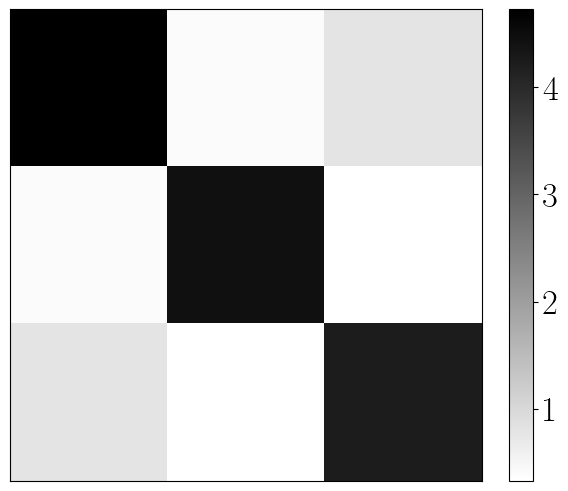

In [10]:
H0 = qt.rand_herm(3, density=1, distribution="pos_def")[:]
plot_matelm_mag(H0, scale="linear")

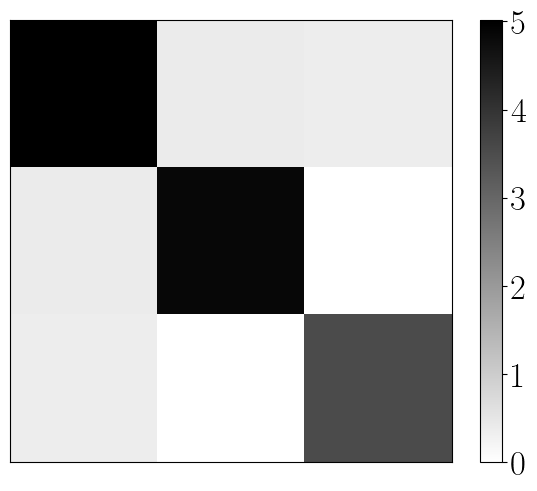

In [11]:
Htest = npad_eliminate_couplings(H0, couplings=[(0, 1), (1, 2)])
plot_matelm_mag(Htest, scale="linear")

Clearly, NPAD reduces the last rotated coupling to almost 0. (Ideally this should be zero. we can check this using tests.) What we need to check is whether it reduces the matrix norm with each rotation. 


# Scaling example

We need to find an example which can saturate the memory of whatever GPU we're going to run this on. Each matrix element is 16 bytes. We want to saturate gigabytes of memory. This is really not that hard, considering quantum systems can get really large really fast. If we keep 3 levels for 10 duffing qubits, we will need a matrix that is roughly 60k x 60k entries, which is r4oughly 5GB, it seems.  Now, we just need to construct a function which will construct the Hamiltonian for such a system. 

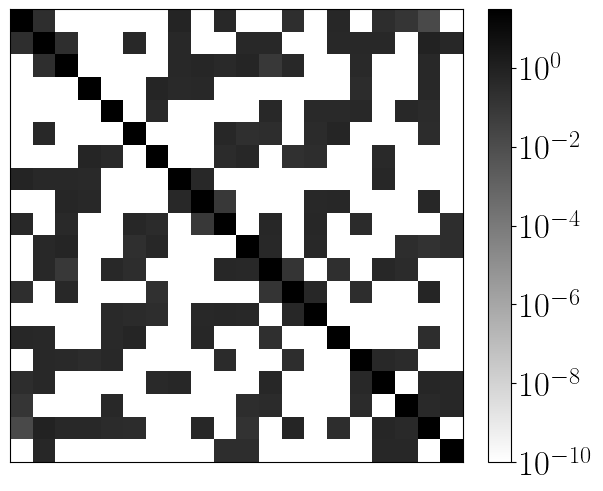

In [24]:
M2 = qt.rand_herm(20, density=0.4, distribution="pos_def")[:]
plot_matelm_mag(M2, scale="log")

In [13]:
M2test = npad_diagonalize(M2)

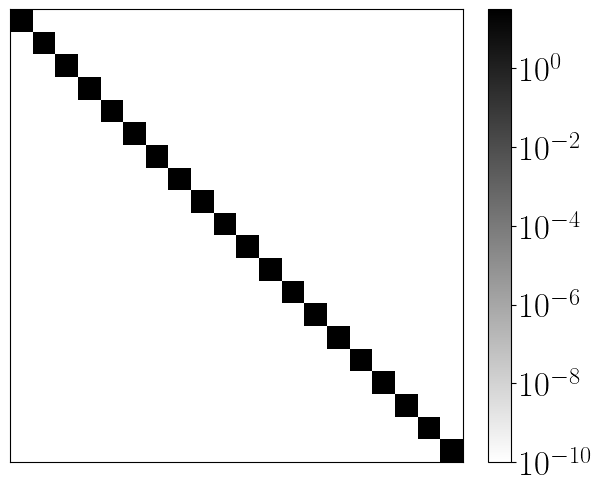

In [14]:
plot_matelm_mag(M2test, scale="log")

In [15]:
la.norm(M2test - np.diag(np.diagonal(M2test)))

9.685282952190237e-11

In [16]:
np.allclose(np.sort(np.real(np.diagonal(M2test))), la.eigvalsh(M2), atol=1e-10)

True


# Checking NPAD norm reduction

Below, we define functions which will compute the norm of all off-diagonal elements of a matrix. This should be easily achieved using `scipy.linalg.norm()`.

In [17]:
def mat_offdiag_norm(H: np.ndarray):
    offdiags = H - np.diag(np.diagonal(H))
    return la.norm(offdiags)

we can now test and see how NPAD reduces the offdiagonal norm with each rotation. We can do this in one shot with our implementation. However, since we want to check how this happens with each rotation, we will do this manually. First, we need to find the indices for nonzero off-diagonal terms. This is simple enough to do. First, we consider the upper triangle of the matrix, then find all nonzero entries. For best results, we should ideally pick the current largest coupling at each step, but it would work even without that.

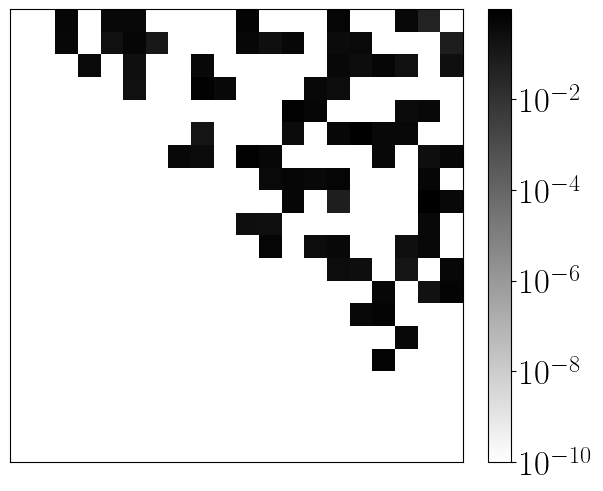

In [21]:
plot_matelm_mag(np.triu(M2, k=1))

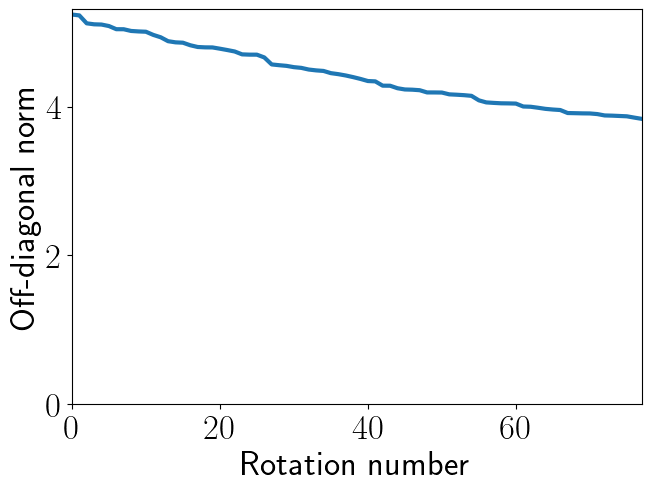

In [41]:
mat_couplins = [
    tuple(coupling) for coupling in np.transpose(np.nonzero(np.triu(M2, k=1)))
]

od_norms = []
M2norm = M2.copy()  # start from the base matrix
# loop through couplings and keep track of matrix norm
for coup in mat_couplins:
    od_norms.append(mat_offdiag_norm(M2norm))
    M2norm = npad_eliminate_couplings(M2norm, couplings=[coup])


fig, ax = plt.subplots(1, 1, layout="constrained")
ax.plot(od_norms)
ax.set(
    # xticks=range(len(od_norms)),
    xlabel="Rotation number",
    ylabel="Off-diagonal norm",
    xlim=(0, len(od_norms) - 1),
    ylim=(0),
)

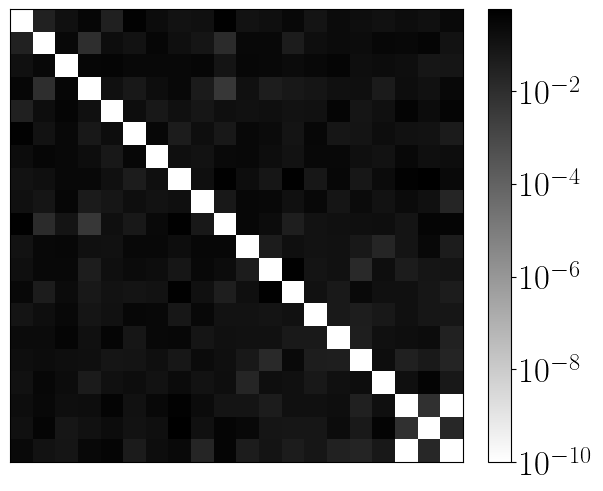

In [39]:
plot_offdiag_mag(M2norm)

Clearly, the matrix off-diagonal norm decreases with each rotation. We should check if this matches the expected value from the expressions in the paper. Based on the arguments presented there, the fastest way to diagonalize (or approach the true diagonal values) is to target the current largest coupling term. We really should implement something that returns the matrices after each rotation, for debugging purposes. 